# Movie Studio  Business Analysis

## Introduction
A new movie studio wants to produce profitable films but lacks insights into the types of movies that perform well at the box office. The goal of this analysis is to identify trends and patterns in movie performance that can guide the studio in selecting and producing successful films.

## Stakeholder
The primary stakeholders are the executives of the new movie studio. They need actionable insights to make informed decisions about which movies to produce, when to release them, and what genres or ratings to prioritize.

## Objectives
1. Explore historical movie data to identify trends in box office performance.
2. Analyze the relationship between movie features (genre, release month, ratings, etc.) and revenue.
3. Provide at least three actionable recommendations for the studio to increase chances of movie success.

# Data Interpretation

We are using multiple datasets from Box Office Mojo, IMDB, and Rotten Tomatoes. These datasets contain movie performance metrics, ratings, and additional attributes that help us understand which factors influence box office success.


In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
import seaborn as sns
import sqlite3
import os
import ast
from collections import Counter
from scipy.stats import ttest_ind

In [168]:
tb = pd.read_csv("../datasets/tmdb.movies.csv")#load the dataset to be able to manipulate it and read it
tb.head(5)# display the first 5 rows of the dataset

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [169]:
tb.info()#describes the details of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [170]:
tb.describe()#summarizes the dataset 

,Unnamed: 0,id,popularity,vote_average,vote_count
count,26517.00000,26517.000000,26517.000000,26517.000000,26517.000000
mean,13258.00000,295050.153260,3.130912,5.991281,194.224837
std,7654.94288,153661.615648,4.355229,1.852946,960.961095
min,0.00000,27.000000,0.600000,0.000000,1.000000
25%,6629.00000,157851.000000,0.600000,5.000000,2.000000
50%,13258.00000,309581.000000,1.374000,6.000000,5.000000
75%,19887.00000,419542.000000,3.694000,7.000000,28.000000
max,26516.00000,608444.000000,80.773000,10.000000,22186.000000


In [171]:
tb.isnull().sum()# check for missing values in the dataset

Unnamed: 0           0
genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [172]:
tb.shape

(26517, 10)

In [173]:
tb.columns

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [174]:
tb.dtypes

Unnamed: 0             int64
genre_ids             object
id                     int64
original_language     object
original_title        object
popularity           float64
release_date          object
title                 object
vote_average         float64
vote_count             int64
dtype: object

In [175]:
tb['title'].value_counts()


title
Eden                             7
Home                             7
Aftermath                        5
Lucky                            5
The Box                          5
                                ..
Real Playing Game                1
Mysteries of the Unseen World    1
The Great Passage                1
The Pardon                       1
Reincarnated                     1
Name: count, Length: 24688, dtype: int64

In [176]:
tb.columns

Index(['Unnamed: 0', 'genre_ids', 'id', 'original_language', 'original_title',
       'popularity', 'release_date', 'title', 'vote_average', 'vote_count'],
      dtype='object')

In [177]:
genre_map = {
    28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy',
    80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family',
    14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music',
    9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction',
    10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'
}


In [178]:
tb['genre_ids_list'] = tb['genre_ids'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])
tb['genres'] = tb['genre_ids_list'].apply(lambda ids: [genre_map[i] for i in ids] if ids else [])

In [179]:
top_popular = tb.sort_values('popularity', ascending=False).head(10)
top_popular[['title', 'genres', 'popularity', 'vote_average', 'vote_count']]


,title,genres,popularity,vote_average,vote_count
23811,Avengers: Infinity War,"[Adventure, Action, Fantasy]",80.773,8.3,13948
11019,John Wick,"[Action, Thriller]",78.123,7.2,10081
23812,Spider-Man: Into the Spider-Verse,"[Action, Adventure, Animation, Science Fiction...",60.534,8.4,4048
11020,The Hobbit: The Battle of the Five Armies,"[Action, Adventure, Fantasy]",53.783,7.3,8392
5179,The Avengers,"[Science Fiction, Action, Adventure]",50.289,7.6,19673
11021,Guardians of the Galaxy,"[Action, Science Fiction, Adventure]",49.606,7.9,17958
20617,Blade Runner 2049,"[Science Fiction, Action, Thriller]",48.571,7.4,6679
23813,Blade Runner 2049,"[Science Fiction, Action, Thriller]",48.571,7.4,6679
23814,Fantastic Beasts: The Crimes of Grindelwald,[Adventure],48.508,6.9,4870
23815,Ralph Breaks the Internet,"[Family, Animation, Comedy, Fantasy, Adventure]",48.057,7.2,2626


In [180]:
top_rated = tb.sort_values('vote_average', ascending=False).head(10)
top_rated[['title', 'genres', 'vote_average', 'vote_count', 'popularity']]


,title,genres,vote_average,vote_count,popularity
26261,The Bubble,"[Documentary, History, War]",10.0,2,0.6
26260,The Roma Project,[Science Fiction],10.0,1,0.6
26259,El Mar La Mar,[Documentary],10.0,2,0.6
26258,Leaning Into the Wind: Andy Goldsworthy,[Documentary],10.0,2,0.6
26257,Black Holler,"[Comedy, Horror]",10.0,1,0.6
26256,Twilight of the Yakuza,[Documentary],10.0,1,0.6
26255,Laura Gets a Cat,"[Comedy, Drama, Romance]",10.0,1,0.6
26254,What About ME?,"[Documentary, History]",10.0,1,0.6
26253,El Gallo,[Drama],10.0,1,0.6
26252,The Doors - Live at the Isle of Wight Festival...,"[Documentary, Music]",10.0,1,0.6


In [181]:
tb['release_year'] = pd.to_datetime(tb['release_date'], errors='coerce').dt.year
yearly_popularity = tb.groupby('release_year')['popularity'].mean()
yearly_popularity.plot(kind='line', figsize=(10,5), title='Average Popularity by Year')


<Axes: title={'center': 'Average Popularity by Year'}, xlabel='release_year'>

In [182]:
lang_popularity = tb.groupby('original_language')['popularity'].mean().sort_values(ascending=False)
lang_popularity.head(10)


original_language
nb    8.221000
sw    7.440000
ja    5.711072
hz    5.495000
uk    5.331000
id    5.187000
af    4.814000
sv    4.799897
mi    4.746000
ko    4.697441
Name: popularity, dtype: float64

In [183]:

tb['genre_ids'] = tb['genre_ids'].apply(eval)


all_genres = [g for sublist in tb['genre_ids'] for g in sublist]

genre_counts = Counter(all_genres)

genre_counts_df = pd.DataFrame(genre_counts.items(), columns=['genre_id', 'movie_count'])
genre_counts_df = genre_counts_df.sort_values('movie_count', ascending=False)
genre_counts_df.head(10)


,genre_id,movie_count
10,18,8303
6,35,5652
18,99,4965
7,53,4207
8,27,3683
4,28,2612
11,10749,2321
5,878,1762
2,10751,1565
9,80,1515


In [184]:

tb_exploded = tb.explode('genre_ids')


genre_popularity = tb_exploded.groupby('genre_ids')['popularity'].mean().reset_index()
genre_popularity = genre_popularity.sort_values('popularity', ascending=False)
genre_popularity.head(10)


,genre_ids,popularity
0,12,7.557082
5,28,6.495047
1,14,6.387318
10,80,5.416396
17,10752,5.320197
12,878,5.238197
9,53,4.840918
13,9648,4.821546
16,10751,4.735889
2,16,4.584240


In [185]:

tb['release_year'] = pd.to_datetime(tb['release_date'], errors='coerce').dt.year

yearly_popularity = tb.groupby('release_year')['popularity'].mean().dropna()
yearly_popularity.head(10)


release_year
1930     9.583000
1933     2.292000
1936     1.653000
1939     0.600000
1946     9.647000
1949     5.439000
1956    10.274000
1957     9.381000
1958     7.223500
1959    13.703333
Name: popularity, dtype: float64

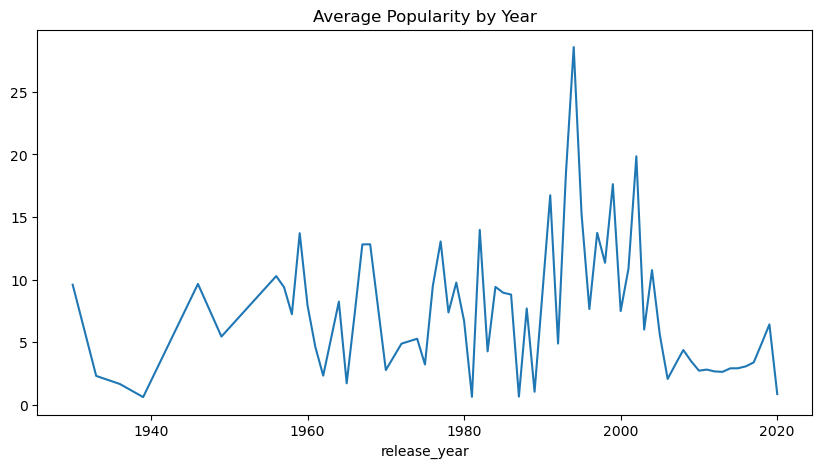

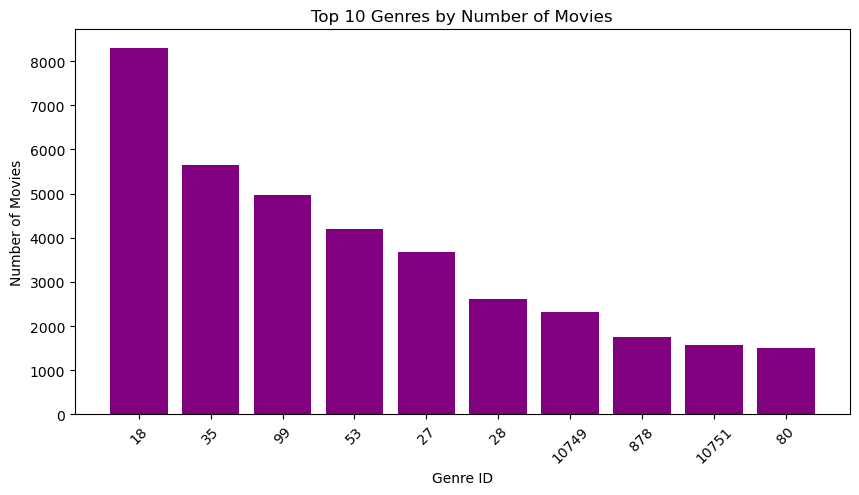

In [186]:
top_genres = genre_counts_df.head(10)

plt.figure(figsize=(10,5))
plt.bar(top_genres['genre_id'].astype(str), top_genres['movie_count'], color='purple')
plt.title('Top 10 Genres by Number of Movies')
plt.xlabel('Genre ID')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

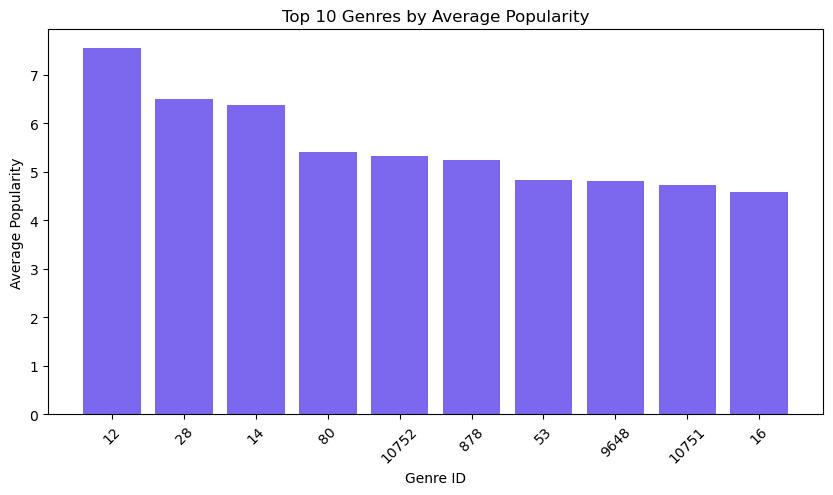

In [187]:
top_genre_popularity = genre_popularity.head(10)

plt.figure(figsize=(10,5))
plt.bar(top_genre_popularity['genre_ids'].astype(str), top_genre_popularity['popularity'], color='mediumslateblue')
plt.title('Top 10 Genres by Average Popularity')
plt.xlabel('Genre ID')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.show()

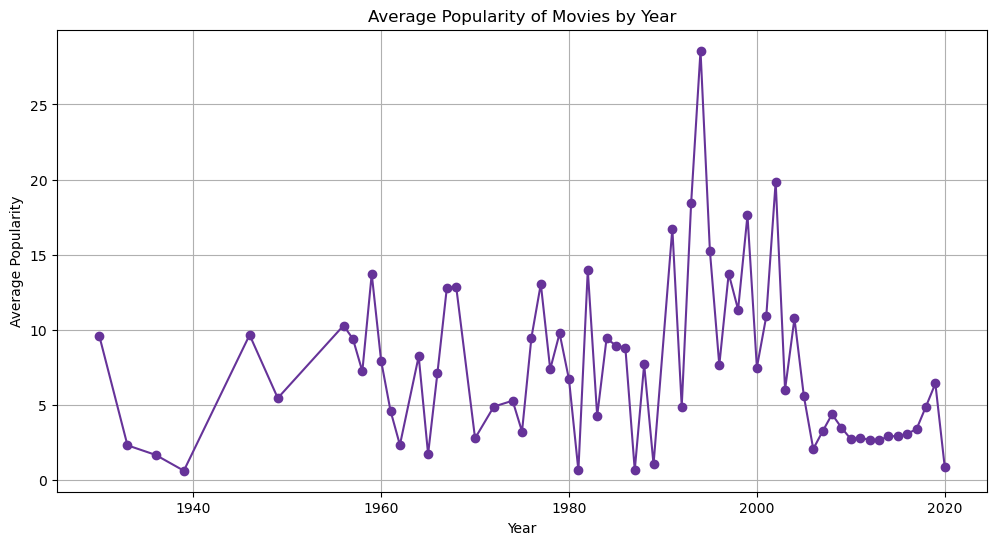

In [188]:
plt.figure(figsize=(12,6))
plt.plot(yearly_popularity.index, yearly_popularity.values, marker='o', color='rebeccapurple')
plt.title('Average Popularity of Movies by Year')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.grid(True)
plt.show()


In [189]:
numeric_cols = ['popularity', 'vote_average', 'vote_count']
corr = tb[numeric_cols].corr()

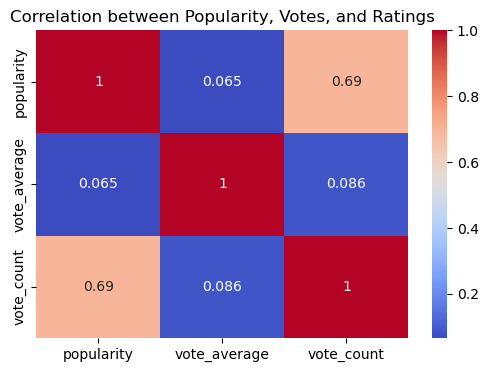

In [190]:
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between Popularity, Votes, and Ratings')
plt.show()

In [191]:
english = tb[tb['original_language']=='en']['popularity']
non_english = tb[tb['original_language']!='en']['popularity']

t_stat, p_val = ttest_ind(english, non_english, equal_var=False)
print("t-statistic:", t_stat, "p-value:", p_val)


t-statistic: -5.538225868823394 p-value: 3.2114751534884845e-08


In [192]:
budget = pd.read_csv("../datasets/tn.movie_budgets.csv")
budget.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [193]:
budget['production_budget'] = budget['production_budget'].replace('[\$,]', '', regex=True).astype(float)
budget['worldwide_gross'] = budget['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
budget['profit'] = budget['worldwide_gross'] - budget['production_budget']


In [194]:
budget.columns

Index(['id', 'release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross', 'profit'],
      dtype='object')

In [195]:
tb['clean_title'] = tb['title'].str.lower().str.strip()
budget['clean_title'] = budget['movie'].str.lower().str.strip()
movies = tb.merge(budget, left_on='clean_title', right_on='clean_title', how='inner')
movies.head()

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,...,genres,release_year,clean_title,id_y,release_date_y,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,...,"[Fantasy, Adventure, Animation, Family]",2010,how to train your dragon,30,"Mar 26, 2010",How to Train Your Dragon,165000000.0,"$217,581,232",494870992.0,329870992.0
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,...,"[Adventure, Action, Science Fiction]",2010,iron man 2,15,"May 7, 2010",Iron Man 2,170000000.0,"$312,433,331",621156389.0,451156389.0
2,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,...,"[Animation, Comedy, Family]",1995,toy story,37,"Nov 22, 1995",Toy Story,30000000.0,"$191,796,233",364545516.0,334545516.0
3,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,...,"[Action, Science Fiction, Adventure]",2010,inception,38,"Jul 16, 2010",Inception,160000000.0,"$292,576,195",835524642.0,675524642.0
4,5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,...,"[Adventure, Fantasy, Family]",2010,percy jackson & the olympians: the lightning t...,17,"Feb 12, 2010",Percy Jackson & the Olympians: The Lightning T...,95000000.0,"$88,768,303",223050874.0,128050874.0


In [196]:
profitable_movies = movies[movies['profit'] > 0]
top_profitable = profitable_movies.sort_values('profit', ascending=False)
top_profitable[['movie', 'production_budget', 'worldwide_gross', 'profit']].head(10)
top_profitable[['movie', 'production_budget', 'worldwide_gross', 'profit']].head(10).style.format({
    'production_budget': '${:,.0f}',
    'worldwide_gross': '${:,.0f}',
    'profit': '${:,.0f}'
})

,movie,production_budget,worldwide_gross,profit
5,Avatar,"$425,000,000","$2,776,345,279","$2,351,345,279"
2238,Avengers: Infinity War,"$300,000,000","$2,048,134,200","$1,748,134,200"
1429,Jurassic World,"$215,000,000","$1,648,854,864","$1,433,854,864"
1432,Furious 7,"$190,000,000","$1,518,722,794","$1,328,722,794"
581,The Avengers,"$225,000,000","$1,517,935,897","$1,292,935,897"
2243,Black Panther,"$200,000,000","$1,348,258,224","$1,148,258,224"
526,Black Panther,"$200,000,000","$1,348,258,224","$1,148,258,224"
2257,Jurassic World: Fallen Kingdom,"$170,000,000","$1,305,772,799","$1,135,772,799"
829,Frozen,"$150,000,000","$1,272,469,910","$1,122,469,910"
110,Frozen,"$150,000,000","$1,272,469,910","$1,122,469,910"


In [197]:
q1 = movies['profit'].quantile(0.25)
q3 = movies['profit'].quantile(0.75)

movies['profit_category'] = np.where(
    movies['profit'] < 0, 'Loss',
    np.where(movies['profit'] >= q3, 'High Profit', 'Moderate Profit')
)

movies[['movie', 'profit', 'profit_category']].head(10)

,movie,profit,profit_category
0,How to Train Your Dragon,3.298710e+08,High Profit
1,Iron Man 2,4.511564e+08,High Profit
2,Toy Story,3.345455e+08,High Profit
3,Inception,6.755246e+08,High Profit
4,Percy Jackson & the Olympians: The Lightning T...,1.280509e+08,High Profit
5,Avatar,2.351345e+09,High Profit
6,Toy Story 3,8.688795e+08,High Profit
7,Despicable Me,4.744646e+08,High Profit
8,Megamind,1.918872e+08,High Profit
9,Toy Story 2,4.213583e+08,High Profit


In [198]:
movies_sorted = movies.sort_values('profit', ascending=False)

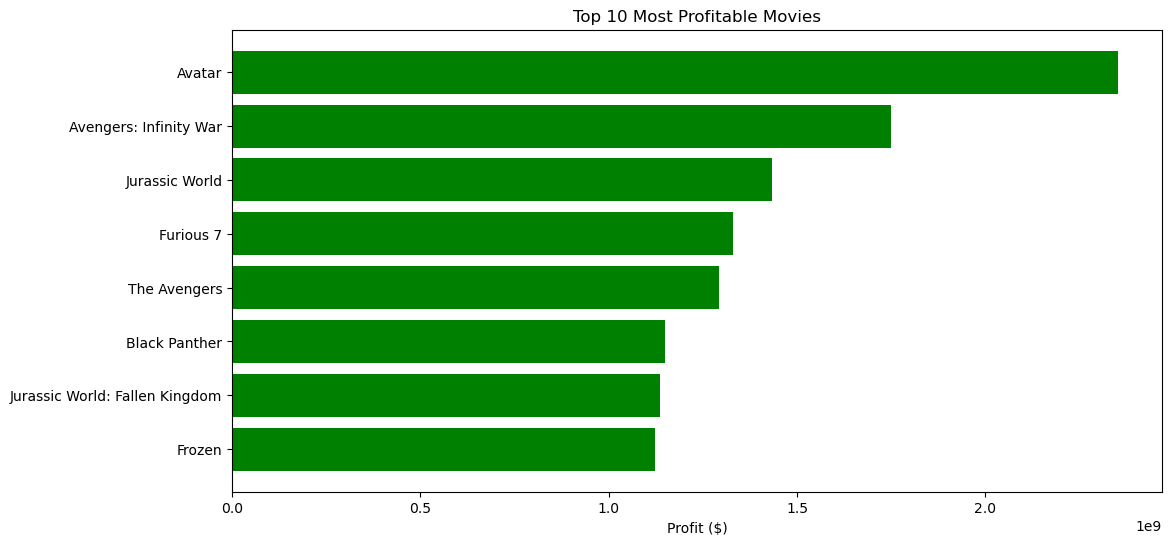

In [199]:
top_movies = movies_sorted.head(10)
colors = ['green' if x > 0 else 'red' for x in top_movies['profit']]

plt.figure(figsize=(12,6))
plt.barh(top_movies['movie'], top_movies['profit'], color=colors)
plt.xlabel('Profit ($)')
plt.title('Top 10 Most Profitable Movies')
plt.gca().invert_yaxis()  
plt.show()


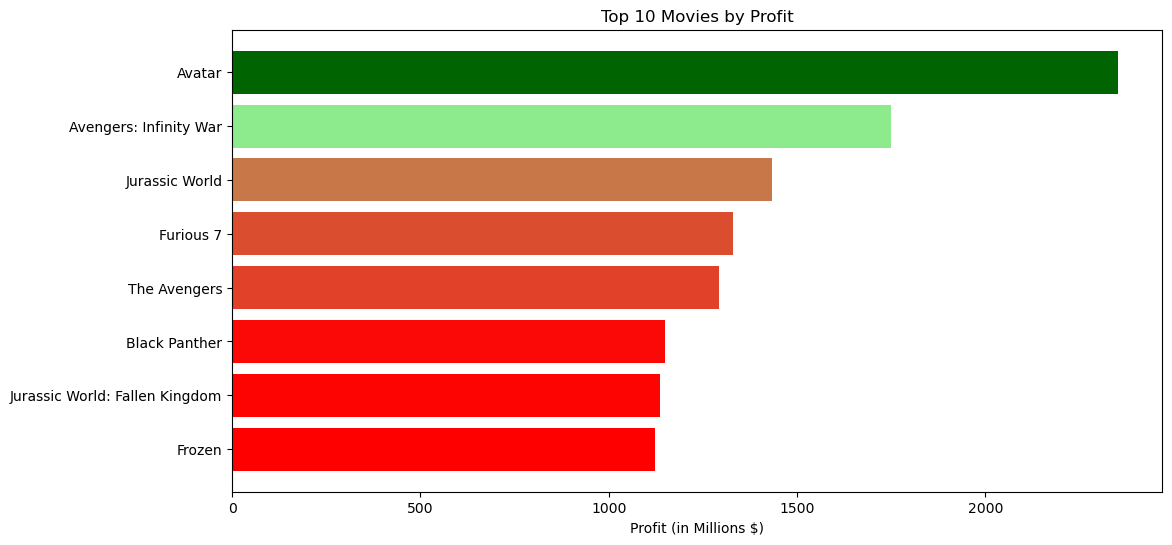

In [200]:

movies_sorted = movies.sort_values('profit', ascending=False)


top_movies = movies_sorted.head(10)

profit_millions = top_movies['profit'] / 1_000_000


norm = mcolors.Normalize(vmin=profit_millions.min(), vmax=profit_millions.max())


cmap = mcolors.LinearSegmentedColormap.from_list('profit_colors', ['red', 'lightgreen', 'darkgreen'])


colors = [cmap(norm(p)) for p in profit_millions]


plt.figure(figsize=(12,6))
plt.barh(top_movies['movie'], profit_millions, color=colors)
plt.xlabel('Profit (in Millions $)')
plt.title('Top 10 Movies by Profit')
plt.gca().invert_yaxis()  
plt.show()

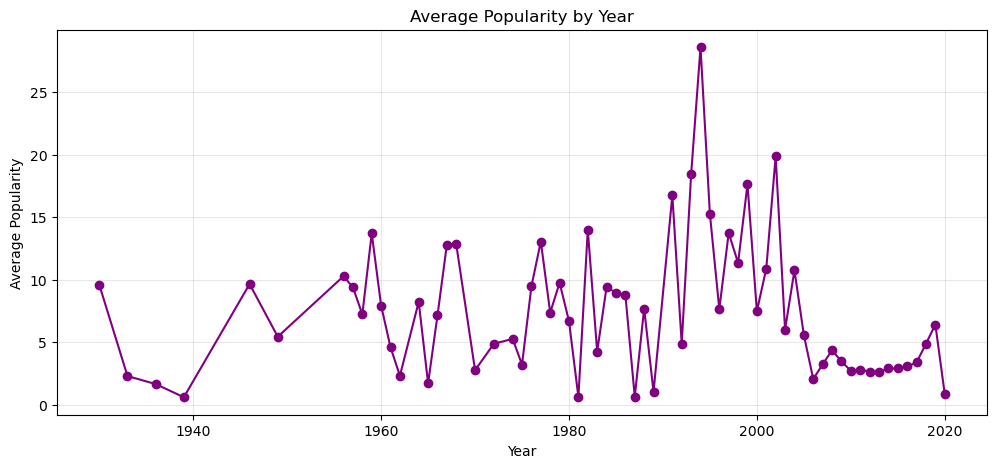

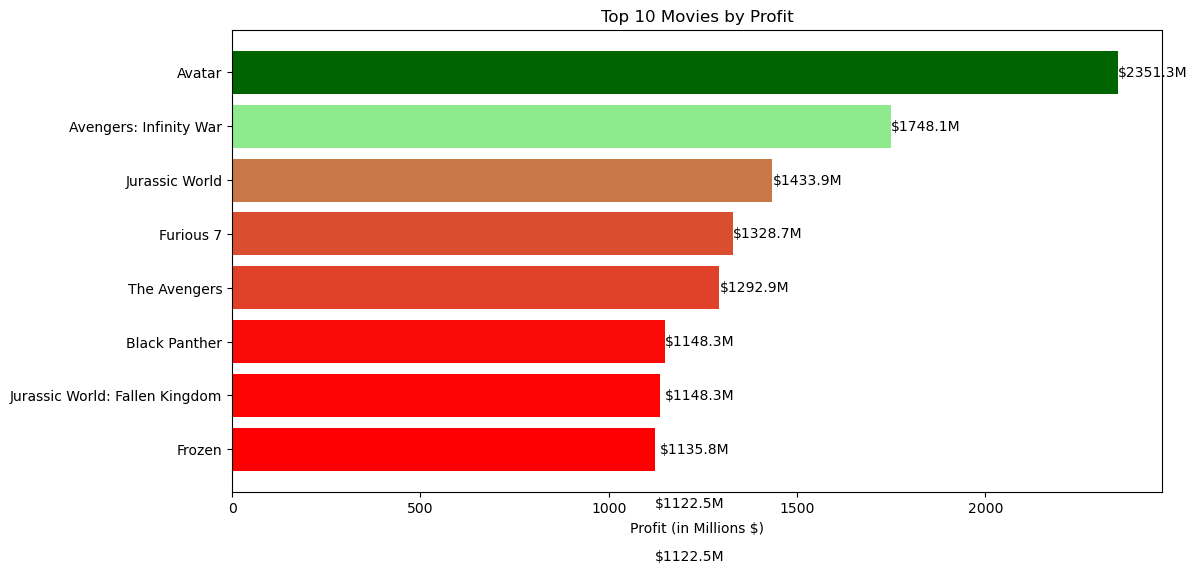

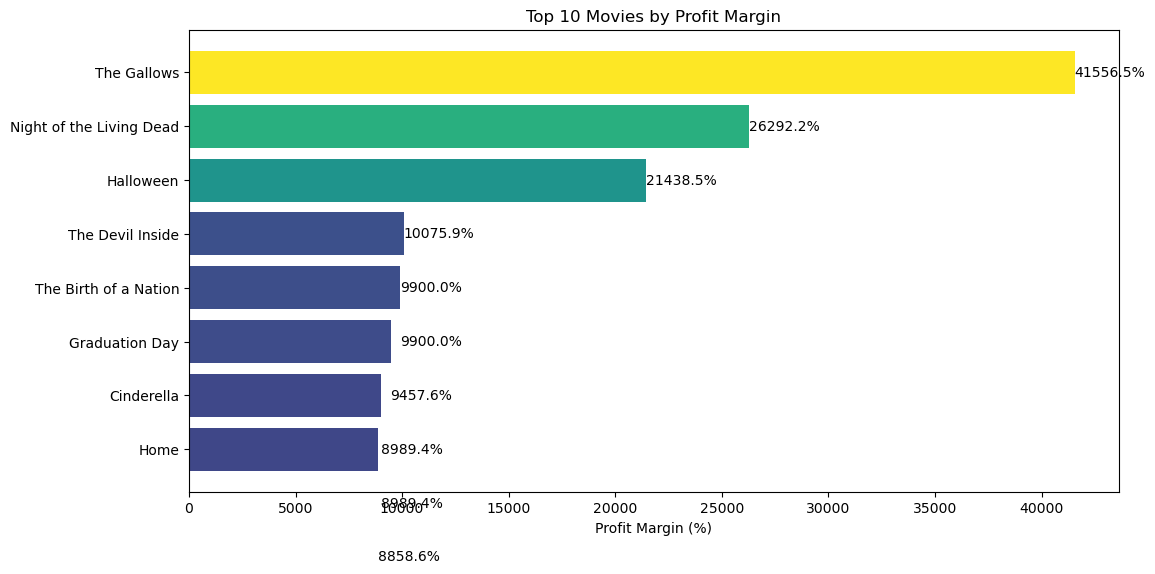

In [202]:



tb['release_year'] = pd.to_datetime(tb['release_date'], errors='coerce').dt.year
yearly_popularity = tb.groupby('release_year')['popularity'].mean()

plt.figure(figsize=(12, 5))
plt.plot(yearly_popularity.index, yearly_popularity.values, marker='o', color='purple')
plt.title('Average Popularity by Year')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.grid(alpha=0.3)
plt.show()



movies_sorted = movies.sort_values('profit', ascending=False)
top_movies = movies_sorted.head(10)
profit_millions = top_movies['profit'] / 1_000_000


norm = mcolors.Normalize(vmin=profit_millions.min(), vmax=profit_millions.max())
cmap = mcolors.LinearSegmentedColormap.from_list('profit_colors', ['red', 'lightgreen', 'darkgreen'])
colors = [cmap(norm(p)) for p in profit_millions]

plt.figure(figsize=(12,6))
plt.barh(top_movies['movie'], profit_millions, color=colors)
plt.xlabel('Profit (in Millions $)')
plt.title('Top 10 Movies by Profit')
plt.gca().invert_yaxis()
for i, v in enumerate(profit_millions):
    plt.text(v + 1, i, f"${v:.1f}M", va='center')
plt.show()



movies['profit_margin'] = (movies['profit'] / movies['production_budget']) * 100
top_margin = movies.sort_values('profit_margin', ascending=False).head(10)
margin_colors = plt.cm.viridis(top_margin['profit_margin'] / top_margin['profit_margin'].max())

plt.figure(figsize=(12,6))
plt.barh(top_margin['movie'], top_margin['profit_margin'], color=margin_colors)
plt.xlabel('Profit Margin (%)')
plt.title('Top 10 Movies by Profit Margin')
plt.gca().invert_yaxis()
for i, v in enumerate(top_margin['profit_margin']):
    plt.text(v + 1, i, f"{v:.1f}%", va='center')
plt.show()
